In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import warnings
import re
warnings.filterwarnings('ignore')
%matplotlib inline

In [20]:
df = pd.read_csv("genes/combined-gene-on-off.csv")
df = df[df['gene_type'].isin({"simple", "intronic_enhancer"})]
df.head(1)

,gene,off-period,on-period,off-mean,on-mean,K-off-rate,K-on-rate,off-median,on-median,off-period-counts,on-period-counts,TATA_group,inr_group,chr_x,strand_x,TSS,geneID,TATA +,YY1 +,SP +,SP -,ETS +,ETS -,NFY +,NFY -,CREB +,CREB -,NRF1 +,NRF1 -,ZNF143 +,ZNF143 -,U1 snRNP +,chr_y,start,end,strand_y,gene_id,transcript_id,distance2tss,celltype,cluster,gene_type,comment
0,LUZP1,"[213, 55, 11, 40]","[7, 7, 2]",79.75,5.333333,0.1875,0.012539,47.5,7.0,4,3,without_TATA,without_inr,chr1,-,23178121.0,ENSG00000169641.9,0.009,0.011,-0.126,-0.16,-0.028,-0.07,0.045,0.065,0.498,0.435,-0.004,0.001,-0.001,-0.067,0.186,chr1,23084023.0,23177808.0,-,ENSG00000169641,NaN,313.0,HBEC,cluster0,simple,NaN


In [21]:
df['gene_type'].value_counts()

simple               47
intronic_enhancer    39
Name: gene_type, dtype: int64

In [22]:
df_off = pd.DataFrame(columns=['gene', 'celltype', 'off-period'])
for index, row in df.iterrows():
    gene = row['gene']
    celltype = row['celltype']

    # Extract off-period values from the string
    off_periods = [int(period) for period in re.findall(r'\d+', row['off-period'])]
    
    # Append each off-period to the new DataFrame
    for off_period in off_periods:
        if off_period >= 2:
            df_off = df_off.append({'gene': gene, 'celltype': celltype, 'off-period': off_period}, ignore_index=True)


df_off['off-period'] = df_off['off-period'].astype(int)
df_off = pd.merge(df_off, df.drop('off-period', axis=1), on=["gene", "celltype"])
df_off.shape

(5966, 43)

In [23]:
df_off.celltype.value_counts()

HBEC    3981
H9D3    1279
H9D0     706
Name: celltype, dtype: int64

In [24]:
df_off.head(1)

,gene,celltype,off-period,on-period,off-mean,on-mean,K-off-rate,K-on-rate,off-median,on-median,off-period-counts,on-period-counts,TATA_group,inr_group,chr_x,strand_x,TSS,geneID,TATA +,YY1 +,SP +,SP -,ETS +,ETS -,NFY +,NFY -,CREB +,CREB -,NRF1 +,NRF1 -,ZNF143 +,ZNF143 -,U1 snRNP +,chr_y,start,end,strand_y,gene_id,transcript_id,distance2tss,cluster,gene_type,comment
0,LUZP1,HBEC,213,"[7, 7, 2]",79.75,5.333333,0.1875,0.012539,47.5,7.0,4,3,without_TATA,without_inr,chr1,-,23178121.0,ENSG00000169641.9,0.009,0.011,-0.126,-0.16,-0.028,-0.07,0.045,0.065,0.498,0.435,-0.004,0.001,-0.001,-0.067,0.186,chr1,23084023.0,23177808.0,-,ENSG00000169641,NaN,313.0,cluster0,simple,NaN


In [29]:
def plot_enhancer_type(data,  title, col = 'off-period'):
    
    order = ['simple', 'intronic_enhancer']

#     plt.figure(figsize=(10, 6))
#     sns.violinplot(x="gene_type", y=col, data=data, palette="Set2", order=order)
#     sns.stripplot(x="gene_type", y=col, data=data, color='black', size=3, jitter=True, order=order)

    
#     plt.title(title)
#     plt.ylabel(col)
#     plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x="gene_type", y=col, data=data, palette="Set2", order=order)
    plt.title(title )
    plt.ylabel(col);
    mean_values = data.groupby('gene_type')[col].median()
    gene_counts = data.groupby('gene_type')['gene'].nunique()
    off_period_counts = data.groupby('gene_type').size()
    new_labels = [f'{o} (n-genes={gene_counts[o]}, n-off-period={off_period_counts[o]})' for o in order]

    plt.xticks(ticks=range(len(new_labels)), labels=new_labels)
    for i, label in enumerate(order):
        plt.text(i, mean_values[label], f'{mean_values[label]:.2f}', ha='center', va='bottom', color='red')

    d1 = data[data['gene_type'] == 'simple'][col]
    d2 = data[data['gene_type'] == 'intronic_enhancer'][col]
    stat, p = mannwhitneyu(d1, d2)
    # Annotate plot with the significance level
    x1, x2 = 0, 1  # x coordinates for the two categories you're comparing
    y, h, color = data[col].max() , 1, 'k'  # y position and height for the line, and color
    plt.plot([x1, x2], [y, y], lw=1.5, c=color)
    plt.text((x1+x2)*.5, y,  f'p = {p:.3e}' if p < 0.05 else f'p = {p:.4f}', ha='center', va='bottom', color=color)

    plt.show()
    
# gene level， none are sigfinicant
# plot_enhancer_type(df[df.celltype=="HBEC"], f'gene level off-period-mean HEBC', col = 'off-mean')
# plot_enhancer_type(df[df.celltype=="H9D0"], f'gene level off-period-mean H9D0', col = 'off-mean')
# plot_enhancer_type(df[df.celltype=="H9D3"], f'gene level off-period-mean H9D3', col = 'off-mean')
# plot_enhancer_type(df[df.celltype!="HBEC"], f'gene level off-period-mean combine H9D0/H9D3', col = 'off-mean')
# plot_enhancer_type(df, f'gene level off-period-mean  -- combine HEBC/H9D0/H9D3', col = 'off-mean')


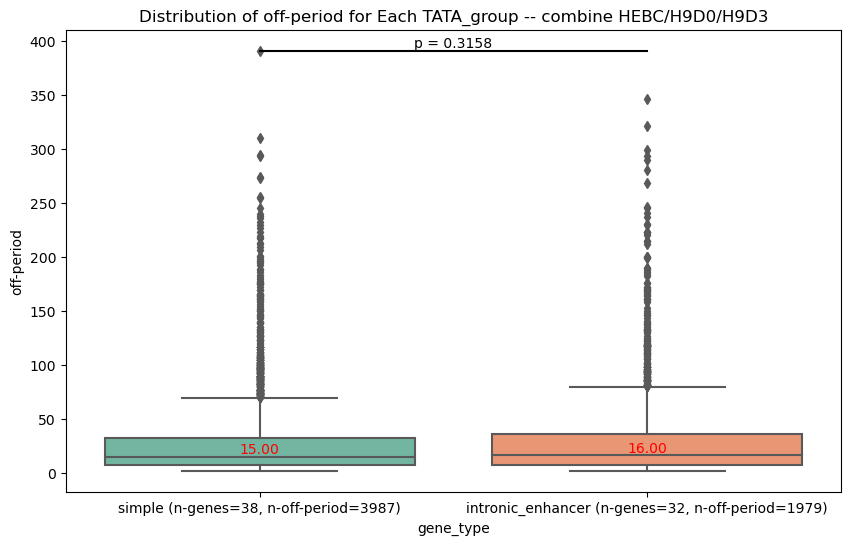

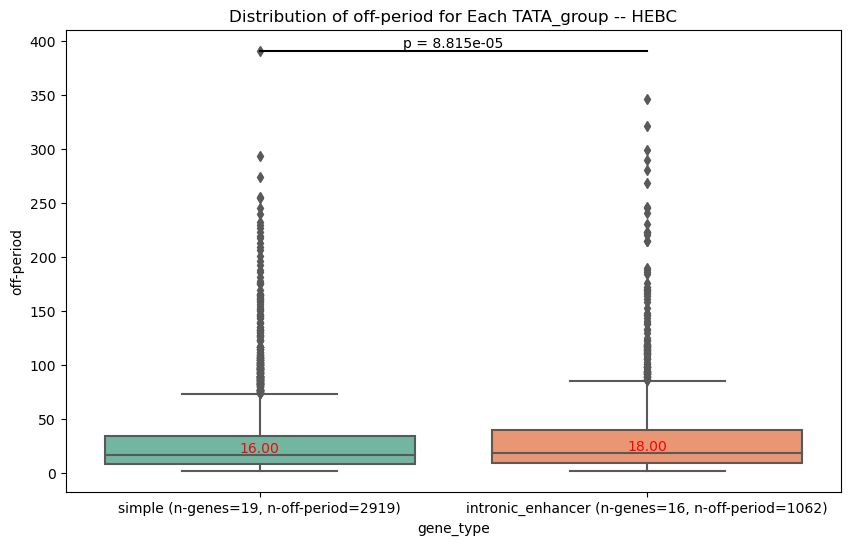

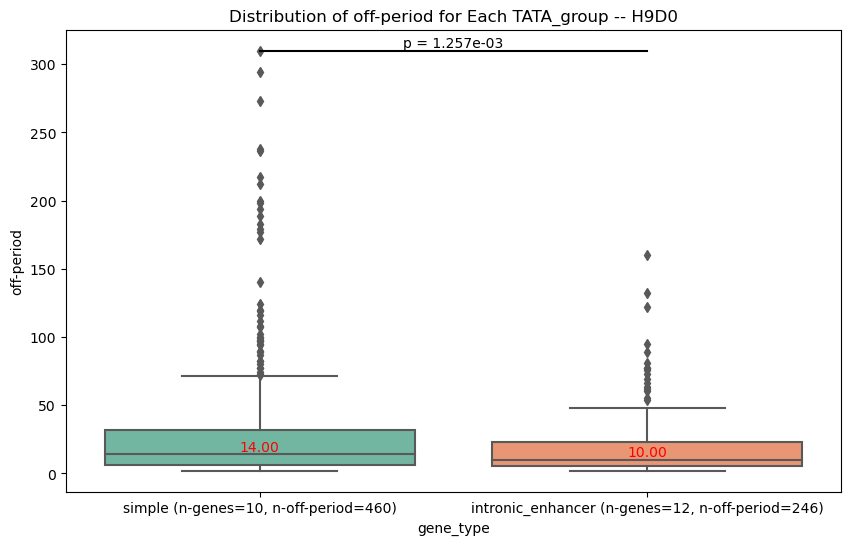

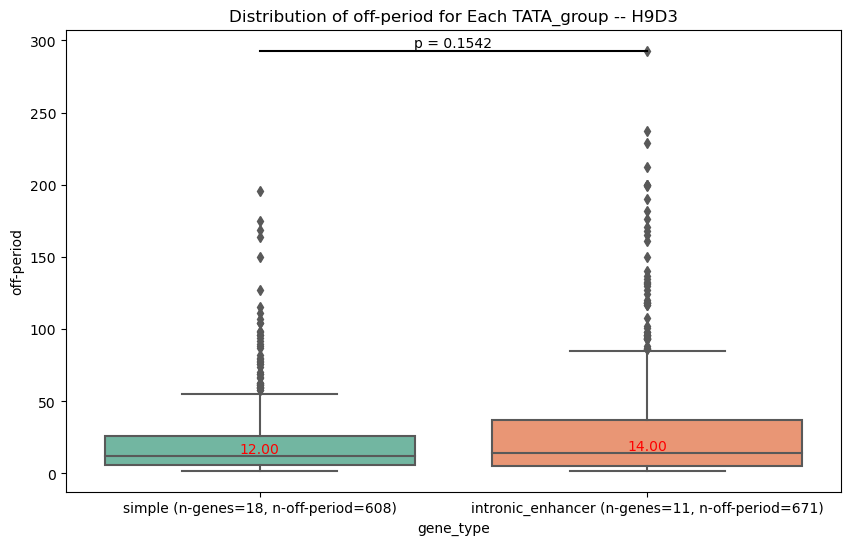

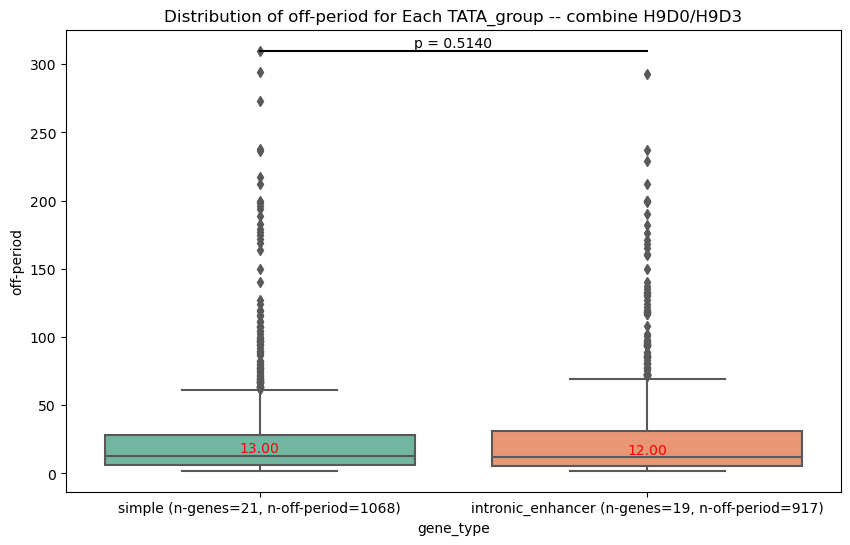

In [30]:
data = df_off
plot_enhancer_type(data, f'Distribution of off-period for Each TATA_group -- combine HEBC/H9D0/H9D3')
plot_enhancer_type(data[data.celltype=="HBEC"], f'Distribution of off-period for Each TATA_group -- HEBC')
plot_enhancer_type(data[data.celltype=="H9D0"], f'Distribution of off-period for Each TATA_group -- H9D0')
plot_enhancer_type(data[data.celltype=="H9D3"], f'Distribution of off-period for Each TATA_group -- H9D3')
plot_enhancer_type(data[data.celltype!="HBEC"], f'Distribution of off-period for Each TATA_group -- combine H9D0/H9D3')